# Beta Binomial Naive Bayes
Necessary imports and plot functions used over the entire python notebook:

In [1]:
import numpy as np
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve
from math import log

In [2]:
# To plot figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
IMAGES_PATH = "./images"

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Data Retrival and Analysis

In [3]:
data = scipy.io.loadmat('spamData.mat')
Xtrain_total_np, Xtest_np, ytrain_total_np, ytest_np = data['Xtrain'], data['Xtest'], data['ytrain'], data['ytest']
Xtrain_total, Xtest, ytrain_total, ytest = pd.DataFrame(Xtrain_total_np), pd.DataFrame(Xtest_np), pd.DataFrame(ytrain_total_np), pd.DataFrame(ytest_np)
Xtrain_total.shape

(3065, 57)

Saving figure Q1_1_attribute_histogram_plots


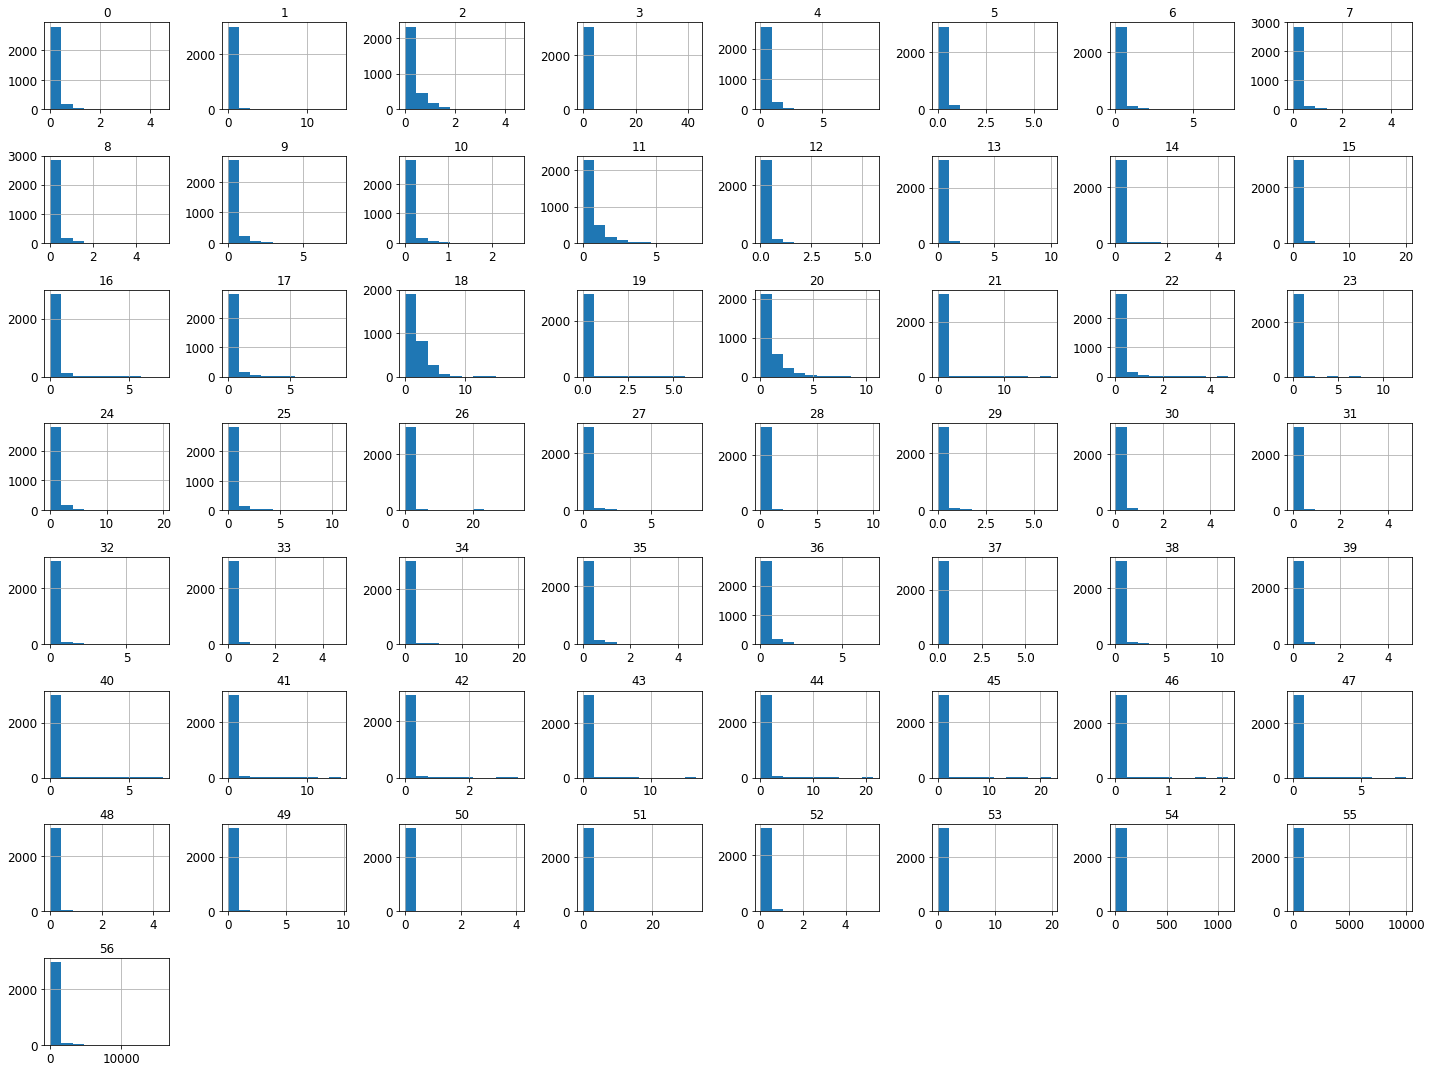

In [16]:
Xtrain_total.hist(bins=10, figsize=(20,15))
save_fig("Q1_1_attribute_histogram_plots")
plt.show()

Here, we see that most of most of the datapoints for all the attributes are concentrated at the value 0. We now split the training data into training and validation data.

In [6]:
ytrain_total[0].value_counts()

0    1833
1    1232
Name: 0, dtype: int64

In [4]:
# to ensure same split in every run
np.random.seed(42)
#Split training data into data from training + validation
def split_train_test(X, y, test_ratio):
    shuffled_indices = np.random.permutation(len(X))
    test_set_size = int(len(X) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return X.iloc[train_indices], X.iloc[test_indices], y.iloc[train_indices], y.iloc[test_indices]

Xtrain, Xvalid, ytrain, yvalid = split_train_test(Xtrain_total, ytrain_total, 0.1)
Xtrain.describe()

,0,1,2,3,4,5,6,7,8,9,...,47,48,49,50,51,52,53,54,55,56
count,2759.000000,2759.000000,2759.000000,2759.000000,2759.00000,2759.000000,2759.000000,2759.000000,2759.000000,2759.000000,...,2759.000000,2759.000000,2759.000000,2759.000000,2759.000000,2759.000000,2759.000000,2759.000000,2759.000000,2759.000000
mean,0.100576,0.223780,0.283835,0.093795,0.30581,0.101327,0.120290,0.101018,0.092211,0.239696,...,0.033577,0.044978,0.144427,0.017892,0.270870,0.076419,0.055491,5.273397,54.358826,296.985502
std,0.289286,1.302077,0.492924,1.753790,0.64149,0.281935,0.408815,0.345716,0.281360,0.571072,...,0.283563,0.283263,0.293732,0.125635,0.907733,0.236040,0.539486,34.190585,228.449540,641.705755
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.583000,7.000000,37.000000
50%,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.071000,0.000000,0.000000,0.000000,0.000000,2.284000,15.000000,98.000000
75%,0.000000,0.000000,0.440000,0.000000,0.40000,0.000000,0.000000,0.000000,0.000000,0.190000,...,0.000000,0.000000,0.191000,0.000000,0.312000,0.055000,0.000000,3.789000,43.000000,286.000000
max,4.540000,14.280000,4.540000,42.810000,9.09000,5.880000,7.270000,4.620000,5.260000,7.550000,...,8.330000,4.385000,9.752000,4.081000,32.478000,5.300000,19.829000,1102.500000,9989.000000,15841.000000


## Data Preprocessing
The assignment description suggests the following different preprocessing techniques:
1. Z-normalization: Standardize each column so they have 0 mean and unit variance, using the empirical mean and empirical variance
2. log-transform: transform each feature using $log(x_{ij}+0.1)$
3. Binarization: binarize features: $\mathbb{I}(x_{ij}>0)$. In other words, if a feature is greater than 0, it is set to 1. If its less than or equal to 0, it's set to 0

In [7]:
eps = np.finfo(float).eps

def log_elem(x):
    return log(x + 0.1)
def binarize_elem(x):
    return 1 if x > eps else 0

def preprocess(X, method="z-norm", mean=None, std=None):
    if method=="z-norm":
        if mean is not None and std is not None:
            for ftr in X.columns:
                X[ftr] = (X[ftr]-mean[ftr])/std[ftr]
        else:
            for ftr in X.columns:
                X[ftr] = (X[ftr]-X[ftr].mean())/X[ftr].std()
        return X
    elif method == "log-transform":
        return X.applymap(log_elem)
    elif method == "binarization":
        return X.applymap(binarize_elem)
    else:
        print("Undefined preprocessing option")

Just to test the above pre-processing function, we perform the preprocessing over a very small artificial sample.

In [21]:
df = pd.DataFrame([[1,2,3],[2,4,6],[4,8,12],[8,16,32]])
print(preprocess(df, "z-norm"))
df = pd.DataFrame([[1,2,3],[2,4,6],[4,8,12],[8,16,32]])
print(preprocess(df, "log-transform"))
df = pd.DataFrame([[1,0,3],[1.2,4,6],[-1,8,12],[8,16,0]])
print(preprocess(df, "binarization"))

          0         1         2
0 -0.888330 -0.888330 -0.785562
1 -0.565301 -0.565301 -0.555641
2  0.080757  0.080757 -0.095800
3  1.372874  1.372874  1.437003
          0         1         2
0  0.095310  0.741937  1.131402
1  0.741937  1.410987  1.808289
2  1.410987  2.091864  2.493205
3  2.091864  2.778819  3.468856
   0  1  2
0  1  0  1
1  1  1  1
2  0  1  1
3  1  1  0


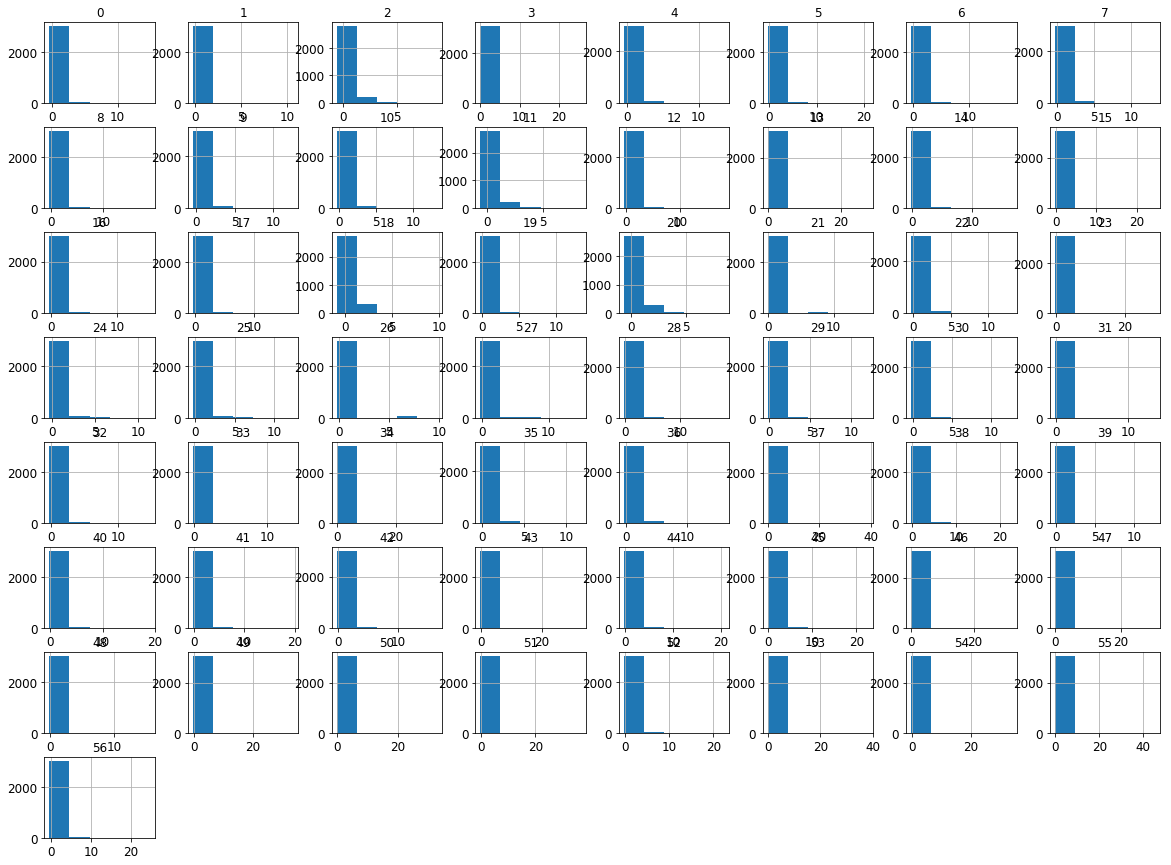

In [18]:
data = scipy.io.loadmat('spamData.mat')
Xtrain_total = pd.DataFrame(data['Xtrain'])
Xtrain_total = preprocess(Xtrain_total, "z-norm")
Xtrain_total.hist(bins=5, figsize=(20,15))
plt.show()

## Constructing the Naive Bayes Estimator
For the first question, we will only be working with the binarized data.

In [10]:
Xtrain = preprocess(Xtrain, "binarization")
Xvalid = preprocess(Xvalid, "binarization")
Xtest = preprocess(Xtest, "binarization")
Xtrain_total = preprocess(Xtrain_total, "binarization")

Saving figure Q1_2_binarized_attributes_histogram


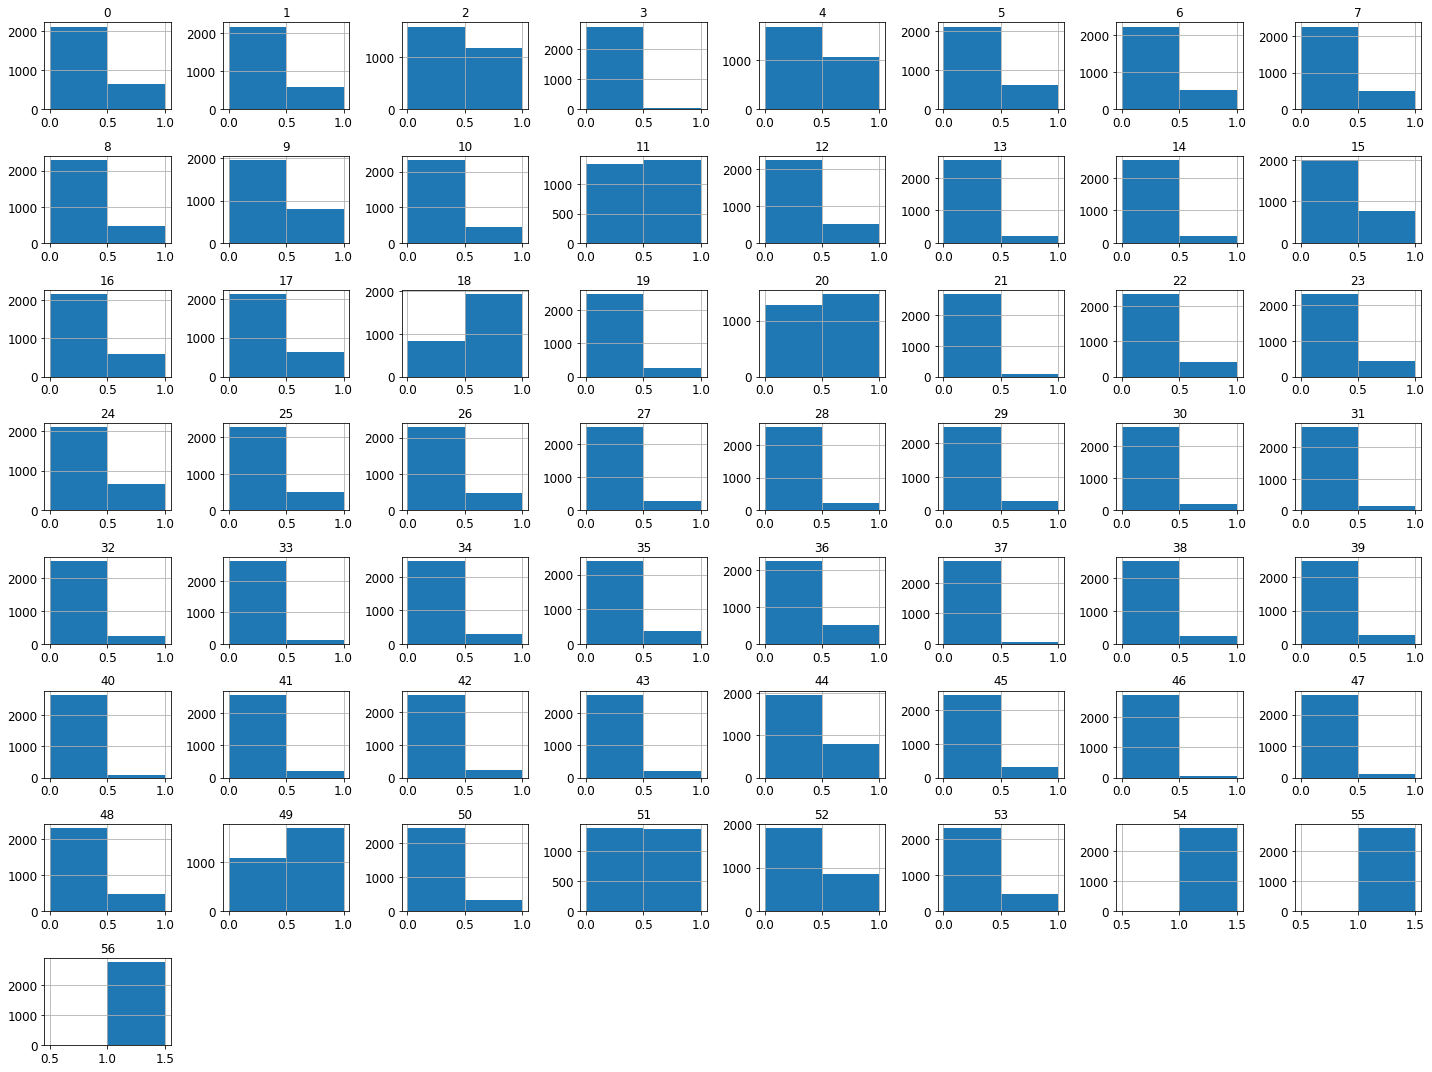

In [21]:
Xtrain.hist(bins=2, figsize=(20,15))
save_fig("Q1_2_binarized_attributes_histogram")
plt.show()

### ML Estimate of class prior, $\lambda$
As the assignment description mentions, we do not assume any priors on the class label. Therefore, we will use $\lambda^{ML}$ for the plug-in approximation, where $\lambda^{ML} = \underset{\lambda}{\operatorname{argmax}} p(y=1|\lambda) = \frac{N_1}{N}$

In [7]:
lambda_ml = np.count_nonzero(ytrain == 1)/len(ytrain)#ML estimate as N1/N
print("lambda_ml = " + str(lambda_ml))

lambda_ml = 0.4015947807176513


### Bayesian (Posterior Predictive) estimate
The feature likelihood parameter, $\eta$ can be defined for each feature $j$ and each class $c$.
When using the posterior predictive method for classification, we calculate $p(\tilde{y} = c | \tilde{x}; D)$ as follows:

$p(\tilde{y} = c | \tilde{x}; D) \propto p(\tilde{y} = c | y_{1:N})\prod_{j=1}^D p(\tilde{x_j} | x_{i\in c,j}, \tilde{y} = c)$

The classifier classifies the new datapoint as the class that maximizes the above probability.
For the purpose of the assignment, we assume that the feature distribution has a prior of $Beta(\alpha,\alpha), \alpha\in \{0, 0.5, 1, 1.5, \ldots, 100\} $, defined as:

$p(\eta_{j,c}|\alpha) \propto Beta(x | \alpha, \alpha) = \frac{x^{\alpha-1}(1-x)^{\alpha-1}}{B(\alpha, \alpha)}$ where $B(\alpha, \alpha) = \frac{2\Gamma(\alpha)}{\Gamma(2\alpha)}$
### Extracting necessary information from data
Naive Bayes invloves calculating various statistics for every class and every feature. Therefore, the data will go through the following steps:
1. Split the data depending on the class
2. For every class $c$, we calculate $p(\tilde{x_{j,c}}=1 | D) = \frac{N_1 + \alpha}{N + 2\alpha}$

In [8]:
def split_on_class(X, y):
    mask = y[0] == 1
    spam = X[mask]
    notSpam = X[~mask]
    return spam, notSpam

In [9]:
Xtrain_spam, Xtrain_notSpam = split_on_class(Xtrain, ytrain)
alpha = [x/2 for x in range(0,201)]
px_jc_spam = np.empty((len(alpha), len(Xtrain_spam[0])))
px_jc_notSpam = np.empty((len(alpha), len(Xtrain_notSpam[0])))
for a in range(len(alpha)):
    for ftr in range(len(Xtrain_spam.columns)):
        count = Xtrain_spam[ftr].value_counts().to_dict()
        value = (count.get(1,0)+alpha[a])/(len(Xtrain_spam)+2*alpha[a])
        px_jc_spam[a][ftr] = value
    for ftr in range(len(Xtrain_notSpam.columns)):
        count = Xtrain_notSpam[ftr].value_counts().to_dict()
        value = (count.get(1,0)+alpha[a])/(len(Xtrain_notSpam)+2*alpha[a])
        px_jc_notSpam[a][ftr] = value

## Classficiation of validation data

In [26]:
ytilde = np.empty((len(alpha), len(Xvalid)))
for a in range(len(alpha)):
    i = 0
    for index, row in Xvalid.iterrows():
        sum_spam, sum_notSpam = log(lambda_ml), log(1-lambda_ml)
        p_spam, p_notSpam = 0, 0
        for ftr in range(len(row)):
            sum_spam += log(max(px_jc_spam[a][ftr],eps)) if row[ftr] else log(max(1-px_jc_spam[a][ftr],eps))
            sum_notSpam += log(max(px_jc_notSpam[a][ftr],eps)) if row[ftr] else log(max(1-px_jc_notSpam[a][ftr],eps))
        ytilde[a][i] = 1 if sum_spam > sum_notSpam else 0
        i += 1

Now we caluclate the error rate for different values of alpha

In [27]:
error_rate = np.empty(len(alpha))
for i in range(len(alpha)):
    error_rate[i] = 1 - accuracy_score(yvalid, ytilde[i], normalize=True)

Saving figure Q1_3_alpha_vs_errorRate


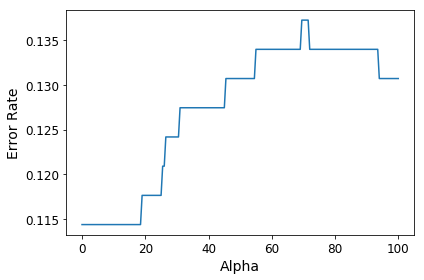

In [28]:
plt.plot(alpha, error_rate)
plt.xlabel("Alpha")
plt.ylabel("Error Rate")
save_fig("Q1_3_alpha_vs_errorRate")

## Classification of Train and Test Data

In [11]:
pestimate = []
ytilde_train = np.empty((len(alpha), len(Xtrain_total)))
ytilde_test = np.empty((len(alpha), len(Xtest)))
for a in range(len(alpha)):
    i = 0
    for index, row in Xtest.iterrows():
        sum_spam, sum_notSpam = log(lambda_ml), log(1-lambda_ml)
        for ftr in range(len(row)):
            sum_spam += log(px_jc_spam[a][ftr]+eps) if row[ftr] else log(1-px_jc_spam[a][ftr]+eps)
            sum_notSpam += log(px_jc_notSpam[a][ftr]+eps) if row[ftr] else log(1-px_jc_notSpam[a][ftr]+eps)
        if a == 0:  #get ROC characteristics for best alpha
            pestimate.append(sum_spam - sum_notSpam)
        ytilde_test[a][i] = 1 if sum_spam > sum_notSpam else 0
        i += 1
    i = 0
    for index, row in Xtrain_total.iterrows():
        sum_spam, sum_notSpam = log(lambda_ml), log(1-lambda_ml)
        for ftr in range(len(row)):
            sum_spam += log(px_jc_spam[a][ftr]+eps) if row[ftr] else log(1-px_jc_spam[a][ftr]+eps)
            sum_notSpam += log(px_jc_notSpam[a][ftr]+eps) if row[ftr] else log(1-px_jc_notSpam[a][ftr]+eps)
        ytilde_train[a][i] = 1 if sum_spam > sum_notSpam else 0
        i += 1

Minimum test error: 0.1171875
Alpha value for minimum test error: 100.0
Confusion matrix for minimum test error: 
[[888  67]
 [156 425]]
Saving figure Q1_4_alpha_vs_errorRate
Test Error rate for alpha = 1: 0.11848958333333337
Test Error rate for alpha = 10: 0.12434895833333337
Test Error rate for alpha = 100: 0.14518229166666663
Train Error rate for alpha = 1: 0.10962479608482867
Train Error rate for alpha = 10: 0.11549755301794451
Train Error rate for alpha = 100: 0.1373572593800979


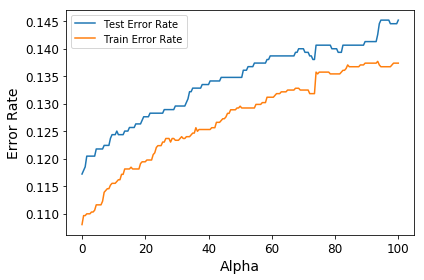

In [12]:
error_rate_test = np.empty(len(alpha))
error_rate_train = np.empty(len(alpha))
for i in range(len(alpha)):
    error_rate_test[i] = 1 - accuracy_score(ytest, ytilde_test[i], normalize=True)
    error_rate_train[i] = 1 - accuracy_score(ytrain_total, ytilde_train[i], normalize=True)

min_error = error_rate_test.min()
min_a = error_rate_test.argmin()
print("Minimum test error: " + str(min_error))
print("Alpha value for minimum test error: " + str(alpha[a]))
print("Confusion matrix for minimum test error: ")
print(confusion_matrix(ytest, ytilde_test[a]))

plt.plot(alpha, error_rate_test, label="Test Error Rate")
plt.plot(alpha, error_rate_train, label="Train Error Rate")
plt.xlabel("Alpha")
plt.ylabel("Error Rate")
plt.legend()
save_fig("Q1_4_alpha_vs_errorRate")
print("Test Error rate for alpha = 1: " + str(error_rate_test[2]))
print("Test Error rate for alpha = 10: " + str(error_rate_test[20]))
print("Test Error rate for alpha = 100: " + str(error_rate_test[200]))
print("Train Error rate for alpha = 1: " + str(error_rate_train[2]))
print("Train Error rate for alpha = 10: " + str(error_rate_train[20]))
print("Train Error rate for alpha = 100: " + str(error_rate_train[200]))

We see that as we increases alpha, the error rate increases.

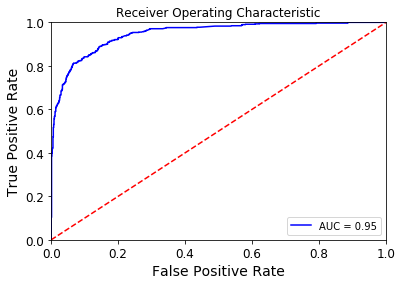

Saving figure Q1_5_ROC_curve


<Figure size 432x288 with 0 Axes>

In [11]:
fpr, tpr, thresholds = roc_curve(ytest, pestimate, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
save_fig("Q1_5_ROC_curve")


Saving figure Q1_6_precision_recall_vs_threshold_plot


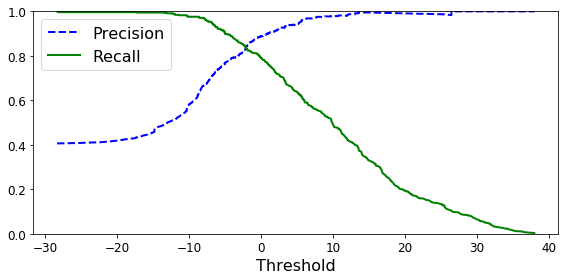

Optimal threshold is: -13.377775580482623


In [12]:
precisions, recalls, thresholds = precision_recall_curve(ytest, pestimate)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
#plt.xlim([-60, -10])
save_fig("Q1_6_precision_recall_vs_threshold_plot")
plt.show()

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Optimal threshold is: " + str(optimal_threshold))

Saving figure Q1_7_precision_vs_recall_plot


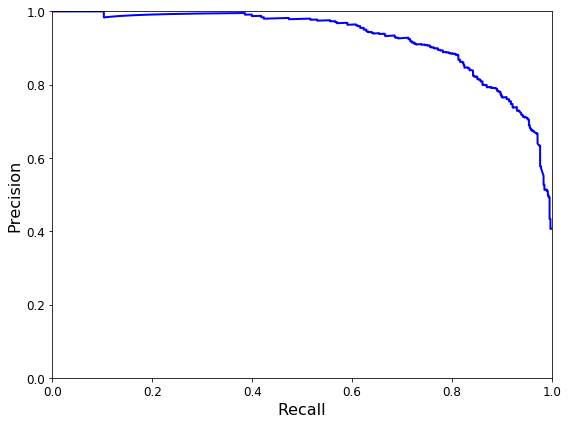

In [13]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
save_fig("Q1_7_precision_vs_recall_plot")
plt.show()

## Custom Naive Bayes Class for future use
Here, we use a class to allow the above calculations to be done easily and systematically. This is a standalone class and does not require any of the above code to run.

In [33]:
from math import log
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

class NaiveBayesBetaBinomial(BaseEstimator, TransformerMixin):
    def __init__(self, alpha = 0.1, threshold = 0):
        self.alpha = alpha
        self.threshold = threshold
    
    def split_on_class(self, X, y):
        mask = y[0] == 1
        spam = X[mask]
        notSpam = X[~mask]
        return spam, notSpam
    
    def fit(self, X, y):
        self.lambda_ml = np.count_nonzero(ytest == 1)/len(ytest)#ML estimate as N1/N
        Xspam, XnotSpam = self.split_on_class(X, y)
        self.px_jc_spam = np.empty(len(Xspam[0]))
        self.px_jc_notSpam = np.empty(len(XnotSpam[0]))
        numColumns = len(Xspam.columns)
        lenSpam = len(Xspam)
        lenNotSpam = len(XnotSpam)
        for ftr in range(numColumns):
            count = Xspam[ftr].value_counts().to_dict()
            value = (count.get(1,0)+self.alpha)/(lenSpam+2*self.alpha)
            self.px_jc_spam[ftr] = value
            count = XnotSpam[ftr].value_counts().to_dict()
            value = (count.get(1,0)+self.alpha)/(lenNotSpam+2*self.alpha)
            self.px_jc_notSpam[ftr] = value
        return self
    
    def transform(self, X):
        ytilde = np.empty(len(X))
        i=0
        for index, row in X.iterrows():
            sum_spam, sum_notSpam = log(self.lambda_ml), log(1-self.lambda_ml)
            for ftr in range(len(row)):
                sum_spam += log(max(self.px_jc_spam[ftr],eps)) if row[ftr] else log(max(1-self.px_jc_spam[ftr],eps))
                sum_notSpam += log(max(self.px_jc_notSpam[ftr],eps)) if row[ftr] else log(max(1-self.px_jc_notSpam[ftr],eps))
            ytilde[i] = 1 if sum_spam - sum_notSpam > self.threshold else 0
            i += 1
        return ytilde

In [43]:
classifier = NaiveBayesBetaBinomial(alpha=0, threshold = -5.38)
classifier.fit(Xtrain, ytrain)
ytilde = classifier.transform(Xvalid)
accuracy = accuracy_score(yvalid, ytilde, normalize=True)
print(1 - accuracy)
ytilde = classifier.transform(Xtest)
accuracy = accuracy_score(ytest, ytilde, normalize=True)
print(1 - accuracy)
print(confusion_matrix(ytest, ytilde))

0.12745098039215685
0.14322916666666663
[[785 170]
 [ 50 531]]


Let us see how the classifier performs if we use the entire training data including the validation data.

In [41]:
Xtrain_total = preprocess(Xtrain_total, "binarization")
classifier = NaiveBayesBetaBinomial(alpha=0, threshold = 0)
classifier.fit(Xtrain_total, ytrain_total)
ytilde = classifier.transform(Xtest)
accuracy = accuracy_score(ytest, ytilde, normalize=True)
print(1 - accuracy)

0.119140625


We see that if we use the entire dataset, the error rate actually increases slightly. The larger training data makes the classifier over fit the data.